In [2]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

Using downloaded and verified file: ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz
Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [51]:
num_inputs = 784
num_outputs = 10

w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad = True)

In [6]:
x = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
x.sum(0, keepdim=True), x.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [7]:
def softmax(x):
    x_exp = torch.exp(x)
    partition = x_exp.sum(1, keepdim=True)
    return x_exp / partition

In [10]:
x = torch.normal(0, 1, (2, 5))
x_prob = softmax(x)
x_prob, x_prob.sum(1)

(tensor([[0.0527, 0.0241, 0.1363, 0.3444, 0.4425],
         [0.1356, 0.0385, 0.2181, 0.0229, 0.5848]]),
 tensor([1.0000, 1.0000]))

In [11]:
# 实现softmax回归模型
def net(x):
    return softmax(torch.matmul(x.reshape((-1, w.shape[0])), w) + b)

In [13]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat, y

(tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]),
 tensor([0, 2]))

In [18]:
y_hat[[0,1], y]    # numpy索引高级语法，等于y_hat[[0,1], [0,2]]  等于y_hat[0,0], y_hat[1,2]

tensor([0.1000, 0.5000])

In [20]:
y_hat[[0,1], [0,2]]

tensor([0.1000, 0.5000])

In [23]:
# 实现交叉熵损失函数
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [42]:
def accuracy(y_hat, y):
    # 计算预测正确的数量
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        print(y_hat)
        # 找到最大的值的索引
        y_hat = y_hat.argmax(axis=1)
        print(y_hat)
    cmp = y_hat.type(y.dtype) == y
    print(cmp)
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]])
tensor([2, 2])
tensor([False,  True])


0.5

## pytorch中net.train()和net.eval()
a) model.eval()，不启用 BatchNormalization 和 Dropout。此时pytorch会自动把BN和DropOut固定住，不会取平均，而是用训练好的值。不然的话，一旦test的batch_size过小，很容易就会因BN层导致模型performance损失较大；

b) model.train() ：启用 BatchNormalization 和 Dropout。 在模型测试阶段使用model.train() 让model变成训练模式，此时 dropout和batch normalization的操作在训练q起到防止网络过拟合的问题。

只进行inference时，model.eval()是必要的，否则会影响结果准确性

In [55]:
def evaluate_accuracy(net, data_iter):
    # 计算在指定数据集上模型的精度
    if isinstance(net, torch.nn.Module):
        # 将模型设置为评估模式
        net.eval()    # 只进行inference时，model.eval()是必要的
    metric = Accumulator(2)  # 正确预测数、预测总数
    for x, y in data_iter:
        metric.add(accuracy(net(x), y), y.numel())
    return metric[0] / metric[1]     # 分类正确的样本数 / 总样本数

In [44]:
class Accumulator:
    # 在n个变量上累加
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

evaluate_accuracy(net, test_iter)

tensor([[0.0974, 0.1026, 0.1099,  ..., 0.1011, 0.1009, 0.1040],
        [0.0810, 0.1186, 0.1042,  ..., 0.0884, 0.1176, 0.1108],
        [0.0899, 0.1052, 0.0937,  ..., 0.0904, 0.0930, 0.1141],
        ...,
        [0.0884, 0.1031, 0.1044,  ..., 0.0970, 0.1016, 0.0931],
        [0.0926, 0.0891, 0.1120,  ..., 0.0993, 0.1133, 0.1031],
        [0.0818, 0.1183, 0.1080,  ..., 0.0968, 0.1069, 0.1084]],
       grad_fn=<DivBackward0>)
tensor([2, 1, 6, 6, 2, 9, 9, 1, 2, 2, 1, 2, 2, 6, 9, 9, 9, 1, 2, 6, 9, 2, 2, 2,
        6, 2, 9, 6, 8, 6, 8, 6, 6, 6, 1, 9, 2, 8, 2, 8, 9, 9, 6, 2, 1, 6, 6, 6,
        6, 6, 2, 2, 5, 9, 1, 2, 2, 1, 2, 6, 5, 5, 8, 5, 6, 6, 6, 6, 2, 9, 5, 9,
        6, 6, 1, 6, 6, 2, 2, 1, 9, 6, 6, 2, 1, 6, 6, 9, 6, 6, 6, 9, 1, 5, 3, 2,
        6, 6, 9, 6, 6, 9, 8, 6, 2, 2, 8, 2, 9, 1, 8, 2, 5, 6, 9, 9, 2, 9, 2, 6,
        6, 6, 2, 8, 6, 6, 8, 6, 3, 2, 9, 6, 2, 6, 2, 2, 2, 6, 1, 2, 5, 6, 6, 6,
        6, 2, 6, 6, 9, 1, 2, 2, 9, 2, 8, 6, 2, 8, 8, 6, 2, 9, 6, 2, 1, 8, 1, 2,
        9, 

        6, 2, 9, 9, 6, 2, 2, 8, 6, 6, 8, 2, 6, 6, 8, 1])
tensor([ True, False, False, False, False, False, False,  True, False,  True,
         True, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,  True,
        False, False,  True, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
       

tensor([5, 6, 9, 6, 6, 2, 9, 8, 1, 2, 8, 6, 9, 6, 9, 6, 2, 6, 8, 9, 9, 6, 6, 6,
        6, 7, 1, 6, 6, 6, 8, 6, 8, 6, 2, 2, 2, 6, 6, 8, 6, 6, 6, 6, 6, 2, 9, 9,
        6, 1, 8, 6, 1, 6, 1, 6, 6, 6, 2, 6, 6, 6, 5, 8, 6, 9, 6, 2, 3, 6, 9, 5,
        5, 2, 8, 6, 8, 6, 6, 3, 2, 2, 6, 2, 5, 6, 6, 6, 2, 6, 6, 2, 6, 6, 2, 9,
        9, 9, 9, 2, 1, 2, 6, 6, 2, 2, 8, 5, 6, 6, 1, 6, 2, 2, 2, 8, 6, 1, 6, 1,
        8, 1, 6, 8, 6, 2, 2, 2, 2, 2, 2, 6, 6, 9, 9, 2, 9, 6, 2, 5, 8, 1, 2, 9,
        6, 1, 6, 6, 6, 5, 9, 2, 8, 3, 9, 1, 5, 6, 6, 1, 6, 2, 6, 6, 2, 1, 2, 2,
        8, 2, 9, 6, 2, 2, 6, 9, 6, 6, 1, 8, 6, 6, 2, 6, 2, 3, 2, 6, 6, 9, 5, 1,
        6, 2, 6, 8, 6, 6, 6, 9, 8, 6, 6, 8, 9, 8, 8, 6, 1, 2, 0, 6, 9, 8, 9, 8,
        6, 6, 2, 6, 8, 9, 2, 5, 6, 6, 6, 6, 9, 3, 5, 2, 2, 9, 9, 9, 8, 9, 2, 8,
        1, 5, 9, 8, 6, 9, 2, 6, 2, 8, 2, 5, 6, 9, 9, 6])
tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, F

0.106

In [45]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [46]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [56]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [57]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

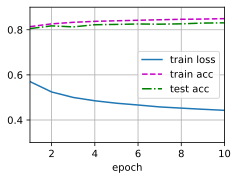

In [58]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### softmax的简洁实现

In [59]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [70]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），将所有的输入转换成2d，来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        # 构建成一个方差0.01的随机正态分布
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
# 输出
net, net.parameters

(Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=784, out_features=10, bias=True)
 ),
 <bound method Module.parameters of Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=784, out_features=10, bias=True)
 )>)

In [67]:
# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [69]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
trainer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

AssertionError: 2.2982993054707843

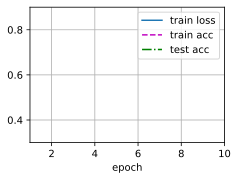

In [71]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)